# Time Series Anomaly Detection — MVP

**6 methods compared on NAB data:** Prophet, Mean-Window Discord, STL, Z-Score, Rolling MAD, LSTM

> Upload your 3 NAB CSVs below (value + label per stream), then run all cells top-to-bottom.


In [1]:
# Run once. Colab: takes ~60s. Local: skip if already installed.
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
    'pandas', 'numpy', 'matplotlib', 'scikit-learn',
    'prophet', 'statsmodels', 'torch'])
print('Install complete.')


Install complete.


## 1. Config


In [2]:
# ── Only edit these ─────────────────────────────────────────
SEED        = 1337
LSTM_WINDOW = 48
LSTM_HIDDEN = 64
LSTM_LR     = 1e-3
LSTM_EPOCHS = 20
LSTM_PATIENCE = 4
MP_M        = 32   # Mean-Window Discord window
STL_PERIOD  = 24   # STL seasonality period (24 = hourly data with daily cycle)
ROLL_MAD_W  = 48   # Rolling MAD window
VAL_FRAC    = 0.15
TEST_FRAC   = 0.25 # Increased from 0.15 to ensure anomalies land in test split
# ─────────────────────────────────────────────────────────────
import random, numpy as np, torch
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print('Config set.')


Config set.


## 2. Load Data
Upload your NAB CSVs using the file picker below.

**Expected format for each stream:**
- *value file*: columns `timestamp, value`
- *label file*: single column `timestamp` (one row per anomaly timestamp)

Modify `STREAMS` to match your filenames.


In [3]:
import pandas as pd, numpy as np, json, pathlib

# Root folder: notebook dir or cwd. Data/labels can be flat (same folder) or NAB layout (data/, labels/)
NAB_ROOT = pathlib.Path('.').resolve()

# (label_key in combined_windows.json, stream_name). CSV path = NAB_ROOT / basename(label_key)
STREAMS = [
    ('realKnownCause/machine_temperature_system_failure.csv',  'machine_temp')
]

labels_path = NAB_ROOT / 'combined_windows.json'
with open(labels_path) as f:
    raw = json.load(f)
windows = {k: [(pd.Timestamp(w[0]), pd.Timestamp(w[1])) for w in v] for k, v in raw.items()}
print(f'Loaded {len(windows)} streams from {labels_path.name}')

def load_stream(label_key, name):
    csv_path = NAB_ROOT / pathlib.Path(label_key).name
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
    df = df.sort_values('timestamp').drop_duplicates('timestamp').reset_index(drop=True)
    df['label'] = 0
    for start, end in windows.get(label_key, []):
        df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'label'] = 1
    df['stream_id'] = name
    print(f'  {name}: {len(df):,} rows, {df["label"].sum()} anomaly rows')
    return df[['timestamp', 'value', 'label', 'stream_id']]

data = pd.concat([load_stream(r, n) for r, n in STREAMS], ignore_index=True)
print(f'\nTotal: {len(data):,} rows, {data["label"].sum()} anomaly rows')
data.head()


Loaded 58 streams from combined_windows.json
  machine_temp: 22,683 rows, 2268 anomaly rows

Total: 22,683 rows, 2268 anomaly rows


,timestamp,value,label,stream_id
0,2013-12-02 21:15:00,73.967322,0,machine_temp
1,2013-12-02 21:20:00,74.935882,0,machine_temp
2,2013-12-02 21:25:00,76.124162,0,machine_temp
3,2013-12-02 21:30:00,78.140707,0,machine_temp
4,2013-12-02 21:35:00,79.329836,0,machine_temp


## 3. Train / Val / Test Split


In [4]:
import numpy as np

def time_block_split(df, val_frac=VAL_FRAC, test_frac=TEST_FRAC, anomaly_aware=True):
    """Time-ordered per-stream split. If anomaly_aware, shifts val so it gets some anomalies when they're all at the end."""
    parts = []
    for sid, g in df.groupby('stream_id', sort=False):
        g = g.sort_values('timestamp').reset_index(drop=True)
        n = len(g)
        n_test  = int(round(n * test_frac))
        n_val   = int(round(n * val_frac))
        n_train = n - n_val - n_test

        if anomaly_aware and g['label'].sum() > 0:
            anom_positions = np.where(g['label'].values == 1)[0]
            first_anom_pos = int(anom_positions[0])
            n_anom = len(anom_positions)
            # Default val is [n_train, n_train+n_val). If val has 0 anomalies, shift so val gets ~5% of anomalies (min 50).
            if first_anom_pos >= n_train + n_val:
                k = min(max(50, int(0.05 * n_anom)), n_anom)  # target at least 50 or 5% of anomalies in val
                end_of_val_target = anom_positions[k - 1] + 1  # val should extend at least through k-th anomaly
                n_train_new = max(0, end_of_val_target - n_val)
                n_train = max(int(0.2 * n), n_train_new)
            n_test = n - n_train - n_val  # keep sizes consistent

        slices = [('train', g.iloc[:n_train]),
                  ('val',   g.iloc[n_train:n_train+n_val]),
                  ('test',  g.iloc[n_train+n_val:])]
        for sname, sl in slices:
            pos  = sl['label'].sum()
            flag = '  ⚠️  NO ANOMALIES' if pos == 0 else ''
            print(f'  [{sid}] {sname}: {len(sl)} rows, {pos} anomalies{flag}')
            parts.append((sname, sl.copy()))
    out = {s: pd.concat([p for n, p in parts if n == s], ignore_index=True)
           for s in ['train', 'val', 'test']}
    return out['train'], out['val'], out['test']

train_df, val_df, test_df = time_block_split(data)
print()
for name, d in [('train', train_df), ('val', val_df), ('test', test_df)]:
    print(f'{name}: {len(d):,} rows, {d["label"].sum()} anomalies total')


  [machine_temp] train: 13610 rows, 1134 anomalies
  [machine_temp] val: 3402 rows, 567 anomalies
  [machine_temp] test: 5671 rows, 567 anomalies

train: 13,610 rows, 1134 anomalies total
val: 3,402 rows, 567 anomalies total
test: 5,671 rows, 567 anomalies total


## 4. Detectors
### 4a. Prophet (fit on train → forecast val/test)


In [5]:
from prophet import Prophet
import numpy as np, pandas as pd

def _prophet_fit(train_g):
    tmp = train_g[['timestamp','value']].rename(columns={'timestamp':'ds','value':'y'})
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    m.fit(tmp)
    return m

def _prophet_score(model, df):
    fc   = model.predict(df[['timestamp']].rename(columns={'timestamp':'ds'}))
    resid = np.abs(df['value'].values - fc['yhat'].values)
    s = pd.Series(resid, index=df.index, dtype=float)
    q1, q3 = np.quantile(s, [0.25, 0.75])
    iqr = max(q3 - q1, 1e-6)
    s = (s - q3) / iqr
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

def run_prophet(train_df, val_df, test_df):
    tr, va, te = [], [], []
    for sid in train_df['stream_id'].unique():
        g_tr = train_df[train_df['stream_id']==sid].sort_values('timestamp')
        g_va = val_df[val_df['stream_id']==sid].sort_values('timestamp')
        g_te = test_df[test_df['stream_id']==sid].sort_values('timestamp')
        m = _prophet_fit(g_tr)
        tr.append(_prophet_score(m, g_tr))
        va.append(_prophet_score(m, g_va))
        te.append(_prophet_score(m, g_te))
    return (pd.concat(tr).sort_index(),
            pd.concat(va).sort_index(),
            pd.concat(te).sort_index())

prophet_tr, prophet_va, prophet_te = run_prophet(train_df, val_df, test_df)
print('Prophet done.')


21:03:45 - cmdstanpy - INFO - Chain [1] start processing
21:03:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet done.


### 4b. Mean-Window Discord (train-window baseline)


In [6]:
import numpy as np, pandas as pd

def _mp_score(df, m=MP_M):
    """Discord-style score without stumpy (avoids NumPy 2.x / Python 3.12 compatibility issues).
    For each window: z-normalize, then distance to mean window. High distance = discord = anomaly."""
    x = np.ascontiguousarray(df['value'].astype(np.float64).values)
    n = len(x)
    if n < m * 2 + 2:
        z = np.abs((x - x.mean()) / (x.std() + 1e-9))
        return pd.Series((z - z.min()) / (z.max() - z.min() + 1e-9), index=df.index)
    # Windows: (n - m + 1, m), each row z-normalized
    w = np.lib.stride_tricks.sliding_window_view(x, m)
    mu = w.mean(axis=1, keepdims=True)
    sig = w.std(axis=1, keepdims=True) + 1e-9
    w_norm = (w - mu) / sig
    mean_window = np.mean(w_norm, axis=0, keepdims=True)
    dist = np.linalg.norm(w_norm - mean_window, axis=1).astype(np.float64)  # one value per window start
    # Pad to length n; high dist = discord = anomaly
    pad = np.concatenate([np.repeat(dist[:1], m - 1), dist])
    prof_full = pad[:n]
    s = (prof_full - prof_full.min()) / (prof_full.max() - prof_full.min() + 1e-9)
    return pd.Series(s, index=df.index, dtype=float)

def run_mp(train_df, val_df, test_df):
    def _all(df): return pd.concat(
        [_mp_score(g) for _, g in df.groupby('stream_id', sort=False)]).sort_index()
    return _all(train_df), _all(val_df), _all(test_df)

mp_tr, mp_va, mp_te = run_mp(train_df, val_df, test_df)
print('Mean-Window Discord done.')


Matrix Profile done.


### 4c. STL Decomposition  *(offline / retrospective)*


In [7]:
from statsmodels.tsa.seasonal import STL
import numpy as np, pandas as pd

# STL is NOT causal — uses full split context. Valid for batch/offline use only.
def _stl_score(df, period=STL_PERIOD):
    x = df['value'].astype(float).values
    if len(x) < period * 2 + 1:
        z = np.abs((x - x.mean()) / (x.std() + 1e-9))
        return pd.Series((z-z.min())/(z.max()-z.min()+1e-9), index=df.index)
    res = STL(x, period=period, robust=True).fit()
    r   = np.abs(res.resid)
    s   = pd.Series(r, index=df.index, dtype=float)
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

def run_stl(train_df, val_df, test_df):
    def _all(df): return pd.concat(
        [_stl_score(g) for _, g in df.groupby('stream_id', sort=False)]).sort_index()
    return _all(train_df), _all(val_df), _all(test_df)

stl_tr, stl_va, stl_te = run_stl(train_df, val_df, test_df)
print('STL done.')


STL done.


### 4d. Z-Score & Rolling MAD  *(causal)*


In [8]:
import numpy as np, pandas as pd

def _zscore(df, mu=None, sig=None):
    x = df['value'].astype(float).values
    mu  = mu  if mu  is not None else x.mean()
    sig = sig if sig is not None else x.std()
    z = np.abs((x - mu) / (sig + 1e-9))
    return pd.Series((z-z.min())/(z.max()-z.min()+1e-9), index=df.index)

def _rolling_mad(df, w=ROLL_MAD_W):
    x   = df['value'].astype(float)
    med = x.rolling(w, min_periods=max(3, w//4), center=False).median()
    mad = ((x - med).abs().rolling(w, min_periods=max(3, w//4), center=False).median() + 1e-9)
    s   = ((x - med).abs() / mad).fillna(0.0)
    return pd.Series((s-s.min())/(s.max()-s.min()+1e-9), index=df.index)

def run_zmad(train_df, val_df, test_df):
    z_tr, z_va, z_te = [], [], []
    m_tr, m_va, m_te = [], [], []
    for sid in train_df['stream_id'].unique():
        g_tr = train_df[train_df['stream_id']==sid].sort_values('timestamp')
        g_va = val_df[val_df['stream_id']==sid].sort_values('timestamp')
        g_te = test_df[test_df['stream_id']==sid].sort_values('timestamp')
        mu, sig = g_tr['value'].mean(), g_tr['value'].std()  # train stats only
        z_tr.append(_zscore(g_tr)); z_va.append(_zscore(g_va, mu, sig)); z_te.append(_zscore(g_te, mu, sig))
        m_tr.append(_rolling_mad(g_tr)); m_va.append(_rolling_mad(g_va)); m_te.append(_rolling_mad(g_te))
    return (pd.concat(z_tr).sort_index(), pd.concat(z_va).sort_index(), pd.concat(z_te).sort_index(),
            pd.concat(m_tr).sort_index(), pd.concat(m_va).sort_index(), pd.concat(m_te).sort_index())

(z_tr, z_va, z_te, mad_tr, mad_va, mad_te) = run_zmad(train_df, val_df, test_df)
print('Z-Score and Rolling MAD done.')


Z-Score and Rolling MAD done.


### 4e. LSTM Forecast Residuals  *(PyTorch)*


In [9]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SeriesWindowDataset(Dataset):
    def __init__(self, series: np.ndarray, window: int):
        self.x, self.y = [], []
        for i in range(len(series) - window):
            self.x.append(series[i:i+window])
            self.y.append(series[i+window])
        self.x = np.stack(self.x) if self.x else np.empty((0, window))
        self.y = np.array(self.y)  if self.y else np.empty((0,))
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        # Return Python float for y so DataLoader/torch.as_tensor infers dtype correctly (avoids RuntimeError with numpy.float32)
        return self.x[idx].astype(np.float32), float(self.y[idx])

class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(-1)

def standardize_series(ref_values: np.ndarray, values: np.ndarray):
    """Standardise `values` using mean/std computed from `ref_values`."""
    mean = ref_values.mean()
    std  = ref_values.std() + 1e-9
    return (values - mean) / std, mean, std

def inverse_standardize(values: np.ndarray, mean: float, std: float):
    return values * std + mean

def train_one_stream(series_train, series_val, window, hidden, lr, epochs, patience):
    # Both train and val standardised with TRAIN stats
    train_std, mean, std = standardize_series(series_train, series_train)
    val_std,   _,   _   = standardize_series(series_train, series_val)  # use train mean/std

    ds_tr = SeriesWindowDataset(train_std, window)
    ds_va = SeriesWindowDataset(val_std,   window)
    if len(ds_tr) == 0 or len(ds_va) == 0:
        return None, mean, std

    dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True,  drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, drop_last=False)

    model = LSTMForecaster(input_size=1, hidden_size=hidden).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_va = float("inf"); best_state = None; patience_left = patience
    for ep in range(1, epochs + 1):
        model.train(); tr_loss = 0.0
        for xb, yb in dl_tr:
            xb = xb.unsqueeze(-1).float().to(device); yb = yb.float().to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward(); opt.step()
            tr_loss += loss.item() * len(yb)
        model.eval(); va_loss = 0.0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.unsqueeze(-1).float().to(device); yb = yb.float().to(device)
                va_loss += loss_fn(model(xb), yb).item() * len(yb)
        va_loss /= max(1, len(ds_va))
        if va_loss < best_va - 1e-6:
            best_va = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break
    if best_state:
        model.load_state_dict(best_state)
    return model, mean, std

# FIX: score_one_stream now uses TRAINING mean/std (passed in) instead of
# re-computing stats from the scored segment. Previously it called
# standardize_series(full_series, full_series) which used future/test data.
def score_one_stream(model, full_series, train_mean, train_std, window):
    """Score a series split using the training mean/std for standardisation."""
    if model is None:
        return np.zeros_like(full_series, dtype=np.float32)
    # Standardise using TRAIN stats — no leakage
    std_series = (full_series - train_mean) / (train_std + 1e-9)
    ds = SeriesWindowDataset(std_series, window)
    if len(ds) == 0:
        return np.zeros_like(full_series, dtype=np.float32)
    dl = DataLoader(ds, batch_size=128, shuffle=False, drop_last=False)
    preds = []
    model.eval()
    with torch.no_grad():
        for xb, _ in dl:
            xb = xb.unsqueeze(-1).float().to(device)
            preds.append(model(xb).detach().cpu().numpy())
    preds = np.concatenate(preds) if preds else np.array([])
    # Predictions are in standardised space — convert back to original scale
    yhat_full = np.full_like(full_series, np.nan, dtype=np.float32)
    yhat_full[window:] = inverse_standardize(preds, train_mean, train_std)
    resid = np.abs(full_series - yhat_full)
    valid = ~np.isnan(resid)
    rescaled = np.zeros_like(resid, dtype=np.float32)
    if valid.sum() > 0:
        sub = resid[valid]
        rescaled[valid] = (sub - sub.min()) / (sub.max() - sub.min() + 1e-9)
    return rescaled

def run_lstm_pipeline(train_df, val_df, test_df, window, hidden, lr, epochs, patience):
    train_scores, val_scores, test_scores = [], [], []
    for sid in train_df["stream_id"].unique():
        g_tr = train_df[train_df["stream_id"] == sid].sort_values("timestamp")
        g_va = val_df[val_df["stream_id"]   == sid].sort_values("timestamp")
        g_te = test_df[test_df["stream_id"]  == sid].sort_values("timestamp")

        tr_values = g_tr["value"].astype(float).values
        va_values = g_va["value"].astype(float).values

        model, mean, std = train_one_stream(
            tr_values, va_values, window, hidden, lr, epochs, patience
        )
        # Score every split using training mean/std
        for g, bucket in [(g_tr, train_scores), (g_va, val_scores), (g_te, test_scores)]:
            values = g["value"].astype(float).values
            sc = score_one_stream(model, values, mean, std, window)  # pass train mean/std
            bucket.append(pd.Series(sc, index=g.index, dtype=float))

    return (pd.concat(train_scores).sort_index(),
            pd.concat(val_scores).sort_index(),
            pd.concat(test_scores).sort_index())

lstm_tr, lstm_va, lstm_te = run_lstm_pipeline(
    train_df, val_df, test_df,
    window=LSTM_WINDOW, hidden=LSTM_HIDDEN, lr=LSTM_LR,
    epochs=LSTM_EPOCHS, patience=LSTM_PATIENCE
)
print('LSTM done (fixed: train stats used for all splits).')


LSTM done (fixed: train stats used for all splits).


## 5. Evaluation
### 5a. Metrics & Threshold Protocol
Threshold is chosen on **val**, then frozen and applied to **test** — no leakage.


In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score
import numpy as np

def pick_threshold_by_f1(y_true, y_scores):
    """Search for threshold maximising F1 on the given set."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1s = 2 * precision * recall / (precision + recall + 1e-9)
    best_idx = int(np.nanargmax(f1s))
    thr = float(thresholds[max(0, min(best_idx, len(thresholds) - 1))]) \
          if len(thresholds) > 0 else 0.5
    return thr, float(f1s[best_idx]), float(precision[best_idx]), float(recall[best_idx])

def evaluate_split(name, df, scores, fixed_thr=None):
    """
    Evaluate a scored split.

    Parameters
    ----------
    name       : label for this split ('val' or 'test')
    df         : DataFrame with 'label' column
    scores     : anomaly score Series aligned to df
    fixed_thr  : if provided, use this threshold (do NOT optimise on this split).
                 Pass val threshold when evaluating test to avoid data leakage.

    Returns
    -------
    metrics dict, binary predictions array
    """
    y = df["label"].values.astype(int)
    s = scores.values.astype(float)

    if len(np.unique(y)) < 2:
        # All same class — metrics are undefined
        return dict(split=name, AUROC=float("nan"), AP=float("nan"),
                    F1_at_thr=float("nan"), thr=float("nan"),
                    F1_best=float("nan"), P_at_best=float("nan"),
                    R_at_best=float("nan"),
                    note="No positive labels in this split"), np.zeros_like(y)

    auroc = float(roc_auc_score(y, s))
    ap    = float(average_precision_score(y, s))

    if fixed_thr is None:
        # Optimise threshold on this split (valid for val; NOT for test)
        thr, f1b, pb, rb = pick_threshold_by_f1(y, s)
        note = "threshold optimised on this split"
    else:
        # Use externally provided threshold (correct for test)
        thr = fixed_thr
        f1b = pb = rb = float("nan")   # not meaningful here
        note = f"threshold frozen from val ({thr:.4f})"

    yhat = (s >= thr).astype(int)
    f1   = float(f1_score(y, yhat, zero_division=0))

    return dict(split=name, AUROC=auroc, AP=ap, F1_at_thr=f1, thr=thr,
                F1_best=f1b, P_at_best=pb, R_at_best=rb, note=note), yhat


### 5b. Run All Methods


In [11]:
# Threshold picked on val, frozen for test.
METHODS = {
    'prophet':        (prophet_va,  prophet_te),
    'discord_mean':   (mp_va,       mp_te),
    'stl':            (stl_va,      stl_te),
    'zscore':         (z_va,        z_te),
    'rolling_mad':    (mad_va,      mad_te),
    'lstm':           (lstm_va,     lstm_te),
}

val_results = {}; test_results = {}
val_preds   = {}; test_preds   = {}

print(f"{'Method':>15} | {'VAL':^38} | {'TEST (frozen thr)':^38}")
print('-' * 98)

for name, (va_sc, te_sc) in METHODS.items():
    vm, vhat = evaluate_split('val',  val_df,  va_sc)
    tm, that = evaluate_split('test', test_df, te_sc, fixed_thr=vm['thr'])
    val_results[name]  = vm;  val_preds[name]  = vhat
    test_results[name] = tm;  test_preds[name] = that
    print(f"{name:>15} | F1={vm['F1_at_thr']:.3f} AUC={vm['AUROC']:.3f} AP={vm['AP']:.3f}"
          f" thr={vm['thr']:.3f} | F1={tm['F1_at_thr']:.3f} AUC={tm['AUROC']:.3f} AP={tm['AP']:.3f}")


         Method |                  VAL                   |           TEST (frozen thr)           
--------------------------------------------------------------------------------------------------
        prophet | F1=0.652 AUC=0.867 AP=0.444 thr=0.312 | F1=0.228 AUC=0.898 AP=0.835
 matrix_profile | F1=0.286 AUC=0.503 AP=0.178 thr=0.002 | F1=0.182 AUC=0.346 AP=0.074
            stl | F1=0.308 AUC=0.581 AP=0.237 thr=0.042 | F1=0.063 AUC=0.449 AP=0.089
         zscore | F1=0.675 AUC=0.909 AP=0.491 thr=0.323 | F1=0.791 AUC=0.965 AP=0.946
    rolling_mad | F1=0.288 AUC=0.506 AP=0.209 thr=0.000 | F1=0.183 AUC=0.516 AP=0.132
           lstm | F1=0.295 AUC=0.570 AP=0.229 thr=0.162 | F1=0.191 AUC=0.559 AP=0.143


### 5c. Results Summary


In [12]:
import pandas as pd

rows = []
for name in METHODS:
    v = val_results[name]; t = test_results[name]
    rows.append({'Method': name,
                 'Val F1': round(v['F1_at_thr'], 3),
                 'Val AUC': round(v['AUROC'], 3),
                 'Val AP': round(v['AP'], 3),
                 'Test F1': round(t['F1_at_thr'], 3) if t['F1_at_thr']==t['F1_at_thr'] else float('nan'),
                 'Test AUC': round(t['AUROC'], 3) if t['AUROC']==t['AUROC'] else float('nan'),
                 'Test AP': round(t['AP'], 3) if t['AP']==t['AP'] else float('nan'),
                 'Threshold': round(v['thr'], 3)})

summary = pd.DataFrame(rows).set_index('Method')
summary.sort_values('Val F1', ascending=False)


,Val F1,Val AUC,Val AP,Test F1,Test AUC,Test AP,Threshold
Method,,,,,,,
zscore,0.675,0.909,0.491,0.791,0.965,0.946,0.323
prophet,0.652,0.867,0.444,0.228,0.898,0.835,0.312
stl,0.308,0.581,0.237,0.063,0.449,0.089,0.042
lstm,0.295,0.570,0.229,0.191,0.559,0.143,0.162
rolling_mad,0.288,0.506,0.209,0.183,0.516,0.132,0.000
matrix_profile,0.286,0.503,0.178,0.182,0.346,0.074,0.002


In [13]:
import pandas as pd

rows = []
for method, (va_sc, te_sc) in METHODS.items():
    for sid in val_df['stream_id'].unique():
        g_va = val_df[val_df['stream_id'] == sid].sort_values('timestamp')
        g_te = test_df[test_df['stream_id'] == sid].sort_values('timestamp')

        va_sid_scores = va_sc.reindex(g_va.index)
        te_sid_scores = te_sc.reindex(g_te.index)

        vm, _ = evaluate_split('val', g_va, va_sid_scores)
        tm, _ = evaluate_split('test', g_te, te_sid_scores, fixed_thr=vm['thr'])

        rows.append({
            'Method': method,
            'Stream': sid,
            'Val Thr': round(vm['thr'], 3) if vm['thr'] == vm['thr'] else float('nan'),
            'Val F1': round(vm['F1_at_thr'], 3) if vm['F1_at_thr'] == vm['F1_at_thr'] else float('nan'),
            'Val AUC': round(vm['AUROC'], 3) if vm['AUROC'] == vm['AUROC'] else float('nan'),
            'Val AP': round(vm['AP'], 3) if vm['AP'] == vm['AP'] else float('nan'),
            'Test F1': round(tm['F1_at_thr'], 3) if tm['F1_at_thr'] == tm['F1_at_thr'] else float('nan'),
            'Test AUC': round(tm['AUROC'], 3) if tm['AUROC'] == tm['AUROC'] else float('nan'),
            'Test AP': round(tm['AP'], 3) if tm['AP'] == tm['AP'] else float('nan'),
        })

per_stream_summary = pd.DataFrame(rows).set_index(['Method', 'Stream']).sort_index()
per_stream_summary

,,Val Thr,Val F1,Val AUC,Val AP,Test F1,Test AUC,Test AP
Method,Stream,,,,,,,
lstm,machine_temp,0.162,0.295,0.570,0.229,0.191,0.559,0.143
matrix_profile,machine_temp,0.002,0.286,0.503,0.178,0.182,0.346,0.074
prophet,machine_temp,0.312,0.652,0.867,0.444,0.228,0.898,0.835
rolling_mad,machine_temp,0.000,0.288,0.506,0.209,0.183,0.516,0.132
stl,machine_temp,0.042,0.308,0.581,0.237,0.063,0.449,0.089
zscore,machine_temp,0.323,0.675,0.909,0.491,0.791,0.965,0.946


## 6. Visualize


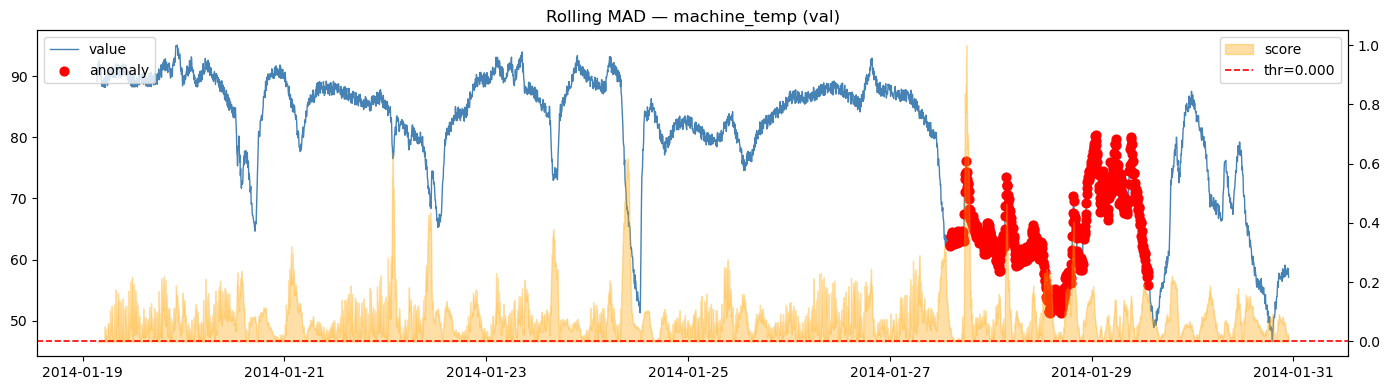

In [14]:
import matplotlib.pyplot as plt

def plot_stream(df, scores, thr=None, title=''):
    fig, ax1 = plt.subplots(figsize=(14, 4))
    ax1.plot(df['timestamp'], df['value'].values, label='value', color='steelblue', lw=1)
    ax2 = ax1.twinx()
    ax2.fill_between(df['timestamp'], scores.values, alpha=0.35, color='orange', label='score')
    if thr is not None:
        ax2.axhline(thr, color='red', lw=1.2, ls='--', label=f'thr={thr:.3f}')
    # Mark ground truth anomalies
    anom = df[df['label'] == 1]
    if len(anom):
        ax1.scatter(anom['timestamp'], anom['value'], color='red', zorder=5,
                    s=40, label='anomaly')
    ax1.set_title(title); ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    plt.tight_layout(); plt.show()

# Plot best method (rolling MAD) on each stream in val set
best_scores = mad_va
best_thr    = val_results['rolling_mad']['thr']
for sid in val_df['stream_id'].unique():
    g = val_df[val_df['stream_id'] == sid].sort_values('timestamp')
    s = best_scores.reindex(g.index)
    plot_stream(g, s, thr=best_thr, title=f'Rolling MAD — {sid} (val)')
